## Import Library

In [1]:
import numpy as np
from scipy.special import sph_harm_y
from scipy import constants as const
from matplotlib import pyplot as plt
from scipy import sparse as sparse
from scipy.sparse import diags
from scipy.sparse.linalg import eigs

## Deklarasi Konstanta

In [45]:
hbar = const.hbar
e = const.e
m_e = const.m_e
pi = const.pi
epsilon_0 = const.epsilon_0
joul_to_eV = e

# Radial part setup
N = 2000
l = 0
r = np.linspace(2e-9, 0.0, N, endpoint=False)

# Azimuthal part setup
N2 = 500
phi = np.linspace(0, 2*np.pi, N2, endpoint=False)
h = phi[1] - phi[0]

# Polar part setup
N3 = 1000
theta = np.linspace(1e-6, np.pi - 1e-6, N3)
h2 = theta[1] - theta[0]
m = 0

## Deklarasi Fungsi untuk Bagian Radial

- `calculate_potential_term` merupakan fungsi yang dibuat untuk menyatakan energi potensial Coulomb yang mengikat antara elektron dengan inti atom, kemudian dinyatakan dalam bentuk matriks diagonal. Persamaan fungsi potensial Coulomb memiliki bentuk sebagai berikut.$$V(r)=\frac{e^2}{4\pi\epsilon_0 r}$$
- `calculate-angular-term` merupakan fungsi yang digunakan untuk memperhitungkan efek momentum sudut atom Hidrogen, kemudian menyusunnya dalam bentuk matriks diagonal. Penambahan fungsi ini dilakukan supaya menambahkan efek momentum sudut pada fungsi radial. Persamaan dinyatakan dalam bentuk berikut:$$\frac{l(l+1)}{r^2}$$
- `calculate-laplace-three-point` merupakan fungsi yang akan menyusun operator turunan kedua $(\nabla^2)$ dengan menggunakan metode beda hingga tiga titik. Laplacian yang disusun menjadi komponen utama dalam perhitungan energi kinetik sistem.$$\nabla^2$$
- `build-hamiltonian` merupakan fungsi yang digunakan untuk menggabungkan seluruh komponen yang sebelumnya telah disusun sehingga membentuk operator Hamiltonian dalam bentuk _sparse matrix_. Matriks ini yang kemudian akan dihitung nilai Eigen dan vektor Eigennya.$$H=-\frac{\hbar^2}{2m}\bigg(\nabla^2-\frac{l(l+1)}{r^2}\bigg)-\frac{e^2}{4\pi\epsilon_0r}$$

In [28]:
def calculate_potential_term(r):
    potential = e**2 / (4.0 * pi * epsilon_0) / r
    potential_term = sparse.diags((potential))
    return potential_term
 
def calculate_angular_term(r):
    angular = l * (l + 1) / r**2
    angular_term = sparse.diags((angular))
    return angular_term
 
def calculate_laplace_three_point(r):
    h = r[1] - r[0]
     
    main_diag = -2.0 / h**2 * np.ones(N)     
    off_diag  =  1.0 / h**2 * np.ones(N - 1)
    laplace_term = sparse.diags([main_diag, off_diag, off_diag], (0, -1, 1))
    return laplace_term
     
def build_hamiltonian(r):
    laplace_term =   calculate_laplace_three_point(r)
    angular_term =   calculate_angular_term(r)
    potential_term = calculate_potential_term(r)
     
    hamiltonian = -hbar**2 / (2.0 * m_e) * (laplace_term - angular_term) - potential_term
 
    return hamiltonian

def plot(r, densities, eigenvalues):
    plt.xlabel('x ($\\mathrm{\AA}$)')
    plt.ylabel('probability density ($\\mathrm{\AA}^{-1}$)')
     
    energies = ['E = {: >5.2f} eV'.format(eigenvalues[i].real / e) for i in range(3)]
    plt.plot(r * 1e+10, densities[0], color='blue',  label=energies[0])
    plt.plot(r * 1e+10, densities[1], color='green', label=energies[1])
    plt.plot(r * 1e+10, densities[2], color='red',   label=energies[2])
     
    plt.legend()
    plt.show()
    return

<>:29: SyntaxWarning: invalid escape sequence '\A'
<>:30: SyntaxWarning: invalid escape sequence '\A'
<>:29: SyntaxWarning: invalid escape sequence '\A'
<>:30: SyntaxWarning: invalid escape sequence '\A'
C:\Users\ASUS\AppData\Local\Temp\ipykernel_8392\545045668.py:29: SyntaxWarning: invalid escape sequence '\A'
  plt.xlabel('x ($\\mathrm{\AA}$)')
C:\Users\ASUS\AppData\Local\Temp\ipykernel_8392\545045668.py:30: SyntaxWarning: invalid escape sequence '\A'
  plt.ylabel('probability density ($\\mathrm{\AA}^{-1}$)')


## Proses Numerik Bagian Radial (r)
Pada bagian ini, langkah pertama adalah menyusun operator Hamiltonian dengan memanggil fungsi `build_hamiltonian`. Setelah didapatkan operator Hamiltonian, kemudian didapatkan nilai Eigen dan vektor Eigen dengan jumlah nilai Eigen yang dicari adalah sebanyak `number_of_eigenvalues`.

Setelah didapatkan masing-masing nilai Eigen dan vektor Eigen, kedua parameter tersebut kemudian akan disimpan dalam suatu array. Nilai Eigen merepresentasikan tingkat energi yang akan disusun berdasarkan energi paling kecil (_ground state_) hingga energi paling besar (eksitasi), sedangkan vektor Eigen merepresentasikan fungsi gelombang bagian radial yang disusun berdasarkan nilai energinya. Berdasarkan array yang dibuat, kemudian dihitung densitas probabilitas dari menemukan elektron pada suatu titik tertentu dengan kuadrat modulus fungsi gelombang yang diperoleh ($|\psi|^2$)

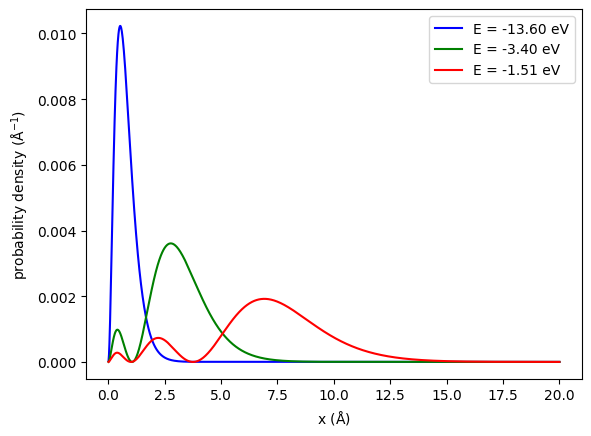

In [29]:
# build Hamiltonian operator
hamiltonian = build_hamiltonian(r)

# solve eigenproblem
number_of_eigenvalues = 100
eigenvalues, eigenvectors = eigs(hamiltonian, k=number_of_eigenvalues, which='SM')
 
# sort eigenvalue and eigenvectors
eigenvectors = np.array([x for _, x in sorted(zip(eigenvalues, eigenvectors.T), key=lambda pair: pair[0])])
eigenvalues = np.sort(eigenvalues)
 
# compute probability density for each eigenvector
densities = [np.absolute(eigenvectors[i, :])**2 for i in range(len(eigenvalues))]

# plot results
plot(r, densities, eigenvalues)

## Proses Numerik Bagian Azimuthal ($\phi$)

Bagian ini merupakan proses penjalanan numerik utama dari bagian azimuthal. Langkah pertama adalah melakukan diskretisasi terhadap operator Laplace sebagai operator turunan kedua. Proses diskretisasi menggunakan metode beda hingga. Kemudian melakukan implementasi syarat batas periodik. Karena sudut $0$ dan $2\pi$ adalah titik yang sama secara fisis, maka ujung-ujung matriks harus "disambungkan".

Selanjutnya, langkah penyelesaian permasalahan Eigen dilakukan untuk memperoleh nilai Eigen dan vektor Eigen bagian azimuthal. Setelah didapatkan kedua parameter tersebut, selanjutnya adalah mengurutkan hasil dalam suatu array.

<>:29: SyntaxWarning: invalid escape sequence '\p'
<>:30: SyntaxWarning: invalid escape sequence '\P'
<>:29: SyntaxWarning: invalid escape sequence '\p'
<>:30: SyntaxWarning: invalid escape sequence '\P'
C:\Users\ASUS\AppData\Local\Temp\ipykernel_8392\1784560556.py:29: SyntaxWarning: invalid escape sequence '\p'
  plt.xlabel("$\phi$ (rad)")
C:\Users\ASUS\AppData\Local\Temp\ipykernel_8392\1784560556.py:30: SyntaxWarning: invalid escape sequence '\P'
  plt.ylabel("$|\Phi(\phi)|^2$")


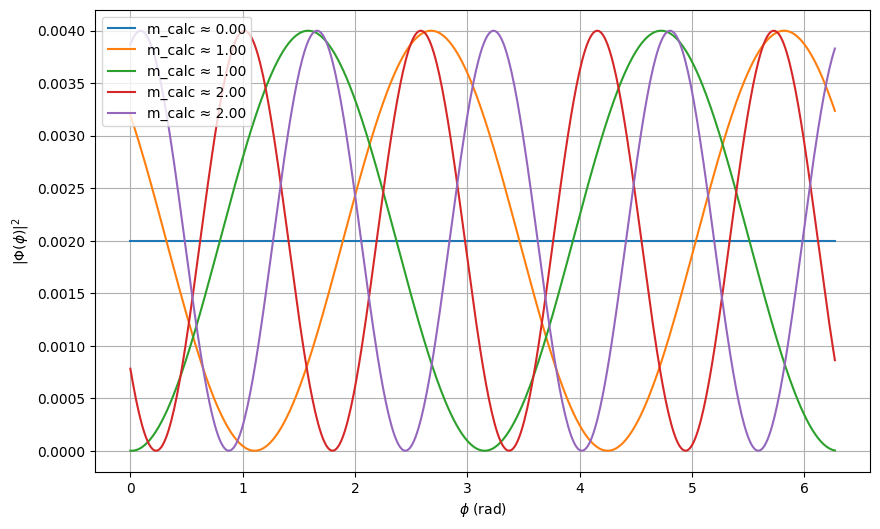

In [ ]:
# Discretization of Laplace Azimuthal Operator
main_diag = -2.0 * np.ones(N2) / h**2 
off_diag  =  1.0 * np.ones(N2-1) / h**2
diagonals = [main_diag, off_diag, off_diag]
L = diags(diagonals, [0, -1, 1]).toarray()

# Periodic Boundary Condition
L[0, N2-1] = 1.0 / h**2
L[N2-1, 0] = 1.0 / h**2

# solve eigenproblem
num_eigenvalues = 10
eigenvalues, eigenvectors = eigs(-L, k=num_eigenvalues, which='SM')

# sort eigenvalue and eigenvector
idx = eigenvalues.argsort()
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:, idx]

plt.figure(figsize=(10, 6))
# taking 3 first state (m=0, m=1, m=2)
for i in range(5):
    m_calc = np.sqrt(np.abs(eigenvalues[i]))
    # Taking real part of eigenvector
    prob_density = np.abs(eigenvectors[:, i])**2
    plt.plot(phi, prob_density, label=f"m_calc ≈ {m_calc:.2f}")

plt.xlabel("$\phi$ (rad)")
plt.ylabel("$|\Phi(\phi)|^2$")
plt.legend()
plt.grid(True)
plt.show()

## Proses Numerik Bagian Polar ($\theta$)

Bagian ini merupakan proses perhitungan numerik untuk bagian polar dari persamaan gelombang. Langkah pertama adalah diskretisasi operator Laplace untuk bagian polar. Diskretisasi akan menyusun operator berbentuk $\frac{d^2}{d\theta^2}+\cot(\theta)\frac{d}{d\theta}$. Selanjutnya diperkenalkan suku potensial efektif. Suku ini memaksa fungsi gelombang supaya bernilai nol di sekitar kutub sehingga membentuk struktur orbital yang sesuai.

Langkah selanjutnya adalah menyusun matriks Hamiltonian untuk bagian polar, kemudian menyelesaikan permasalahan Eigennya.

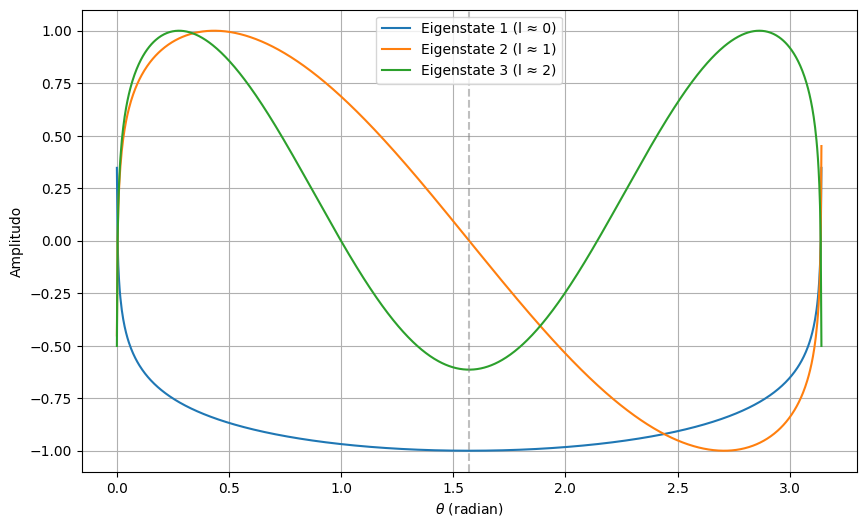

Nilai l hasil kalkulasi (seharusnya 0, 1, 2, ...):
[np.float64(0.15841576583271644), np.float64(1.1832991753892335), np.float64(2.1997836409616047), np.float64(3.212741175646772), np.float64(4.223690231313943)]


In [ ]:
# Discretization of Laplace Polar Operator
d2_diag = -2.0 / h2**2 * np.ones(N3)
d2_off  = 1.0 / h2**2 * np.ones(N3-1)

# First degree derivation times by $cot(\theta)$
cot_theta = 1.0 / np.tan(theta)
d1_upper = cot_theta[:-1] / (2*h2)
d1_lower = -cot_theta[1:] / (2*h2)

# Effective potential (-m^2 / sin^2(theta)):
m_term = - (m**2) / (np.sin(theta)**2)

# Forming Hamiltonian matrix for polar part
main_diag_2 = d2_diag + m_term
upper_diag_2 = d2_off + d1_upper
lower_diag_2 = d2_off + d1_lower

diagonals_2 = [main_diag_2, upper_diag_2, lower_diag_2]
H_polar = diags(diagonals_2, [0, 1, -1]).toarray()

# solve eigenproblem
num_eigenvalues_2 = 5
eigenvalues_2, eigenvectors_2 = eigs(-H_polar, k=num_eigenvalues_2, which='SM')

# sort eigenvalue and eigenvector
idx_2 = eigenvalues_2.argsort()
eigenvalues_2 = eigenvalues_2[idx_2]
eigenvectors_2 = eigenvectors_2[:, idx_2]

plt.figure(figsize=(10, 6))
for i in range(3):
    # calculating l
    l_calc = (-1 + np.sqrt(1 + 4 * np.abs(eigenvalues_2[i]))) / 2
    y_plot = eigenvectors_2[:, i].real
    plt.plot(theta, y_plot / np.max(np.abs(y_plot)), 
             label=f"Eigenstate {i+1} (l ≈ {int(round(l_calc))})")

plt.xlabel(r"$\theta$ (radian)")
plt.ylabel("Amplitudo")
plt.axvline(np.pi/2, color='gray', linestyle='--', alpha=0.5)
plt.legend()
plt.grid(True)
plt.show()

print("Nilai l hasil kalkulasi (seharusnya 0, 1, 2, ...):")
print([(-1 + np.sqrt(1 + 4 * x)) / 2 for x in eigenvalues_2.real])